In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [25]:
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices("GPU"))

Tensorflow version:  2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
dir_path = os.path.join("database", "text_classification")

with open (os.path.join(dir_path, "en.json")) as f:
    data = json.load(f)
    df = pd.DataFrame(data)

df

,text,label
0,Did a pain in the center of the chest ever occ...,chest_pain
1,Did those symptoms changes?,symptoms_changes
2,Did you experienced fainting?,fainting_symptoms
3,Did you faint?,fainting_symptoms
4,Did you had a cough with sputum?,cough_symptoms
...,...,...
71,visit reason,visit_reason
72,visit reason?,visit_reason
73,when did the symptoms start,symptoms_start
74,why are you in the hospital?,visit_reason


In [14]:
df.drop_duplicates(["text"], ignore_index=True)

,text,label
0,Did a pain in the center of the chest ever occ...,chest_pain
1,Did those symptoms changes?,symptoms_changes
2,Did you experienced fainting?,fainting_symptoms
3,Did you faint?,fainting_symptoms
4,Did you had a cough with sputum?,cough_symptoms
...,...,...
71,visit reason,visit_reason
72,visit reason?,visit_reason
73,when did the symptoms start,symptoms_start
74,why are you in the hospital?,visit_reason


In [3]:
df["label"].value_counts()

visit_reason              12
symptoms_start             9
greetings                  8
fever_symptoms             6
diseases_parents           6
surgeries                  5
symptoms_circumstances     5
chest_pain                 4
symptoms_changes           4
fainting_symptoms          4
diseases_personal          4
cough_symptoms             3
palpitations_symptoms      3
chronic_treatment          3
Name: label, dtype: int64

In [4]:
dir_path = os.path.join("database", "personas")

with open(os.path.join(dir_path, "en_personas.json")) as f:
    data = json.load(f)
    texts = []
    labels = []
    for persona in data:
        for dialog_entity in persona["dialog"]:
            if not "questions" in dialog_entity:
                print(dialog_entity)
            
            for question in dialog_entity["questions"]:
                texts.append(question)
                labels.append(dialog_entity["label"])
    df_persona = pd.DataFrame(
        {
            "text": texts,
            "label": labels
        }
    )
df_persona.head()

,text,label
0,What is the reason for the presentation at the...,visit_reason
1,When did the symptoms start?,symptoms_start
2,What are the circumstances of the onset of sym...,symptoms_circumstances
3,Were there any changes in symptoms from onset ...,symptoms_changes
4,Do you know of any illness that your mother or...,diseases_parents


In [19]:
df_persona = df_persona.drop_duplicates(["text"], ignore_index=True)

In [20]:
df_combined = pd.concat([df, df_persona], ignore_index=True)
label_to_idx = {label: idx for idx, label in enumerate(df_combined["label"].unique())}
label_to_idx

{'chest_pain': 0,
 'symptoms_changes': 1,
 'fainting_symptoms': 2,
 'cough_symptoms': 3,
 'surgeries': 4,
 'fever_symptoms': 5,
 'palpitations_symptoms': 6,
 'chronic_treatment': 7,
 'diseases_parents': 8,
 'diseases_personal': 9,
 'greetings': 10,
 'symptoms_start': 11,
 'symptoms_circumstances': 12,
 'visit_reason': 13}

In [32]:
df_combined["label_id"] = df_combined["label"].apply(lambda s: label_to_idx[s])
df_combined.head()

,text,label,label_id
0,Did a pain in the center of the chest ever occ...,chest_pain,0
1,Did those symptoms changes?,symptoms_changes,1
2,Did you experienced fainting?,fainting_symptoms,2
3,Did you faint?,fainting_symptoms,2
4,Did you had a cough with sputum?,cough_symptoms,3


In [33]:
train_df = df_combined.groupby("label").sample(frac=0.8, random_state=42)
valid_df = df_combined.drop(train_df.index)

In [34]:
batch_size = 12

train_dataset = (tf.data.Dataset
                 .from_tensor_slices((train_df["text"], train_df["label_id"]))
                 .batch(batch_size))

valid_dataset = (tf.data.Dataset
                 .from_tensor_slices((valid_df["text"], valid_df["label_id"]))
                 .batch(batch_size))

In [53]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2",
    trainable=True)
encoder_outputs = encoder(encoder_inputs)
outputs = tf.keras.layers.Dense(len(label_to_idx))(encoder_outputs["pooled_output"])

model = tf.keras.Model(inputs=text_input, outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_8 (KerasLayer)     {'input_type_ids':   0           ['input_7[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [55]:
epochs = 100

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset
)

Epoch 1/100
7/7 [==============================] - 7s 384ms/step - loss: 2.9115 - sparse_categorical_accuracy: 0.0952 - val_loss: 2.8254 - val_sparse_categorical_accuracy: 0.0909
Epoch 2/100
7/7 [==============================] - 2s 292ms/step - loss: 2.7421 - sparse_categorical_accuracy: 0.1071 - val_loss: 2.7273 - val_sparse_categorical_accuracy: 0.1818
Epoch 3/100
7/7 [==============================] - 2s 293ms/step - loss: 2.6305 - sparse_categorical_accuracy: 0.1786 - val_loss: 2.6522 - val_sparse_categorical_accuracy: 0.2273
Epoch 4/100
7/7 [==============================] - 2s 305ms/step - loss: 2.5770 - sparse_categorical_accuracy: 0.1548 - val_loss: 2.5927 - val_sparse_categorical_accuracy: 0.2273
Epoch 5/100
7/7 [==============================] - 2s 320ms/step - loss: 2.4955 - sparse_categorical_accuracy: 0.2143 - val_loss: 2.5431 - val_sparse_categorical_accuracy: 0.2273
Epoch 6/100
7/7 [==============================] - 2s 299ms/step - loss: 2.4489 - sparse_categorical_accu

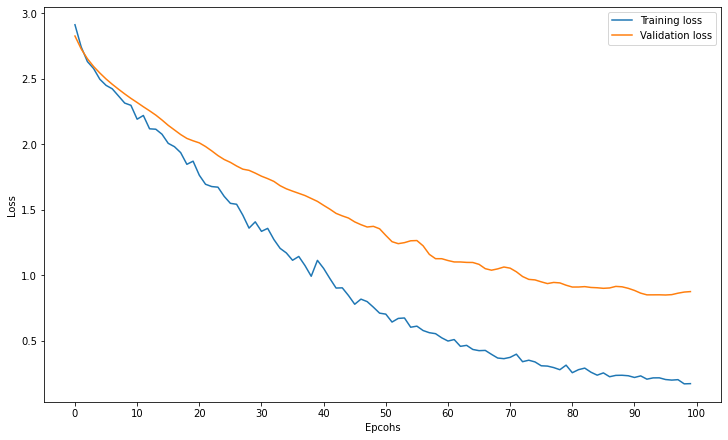

In [56]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, len(history.history["loss"]) + 1, 10))
ax.legend()
# plt.savefig("loss.png")

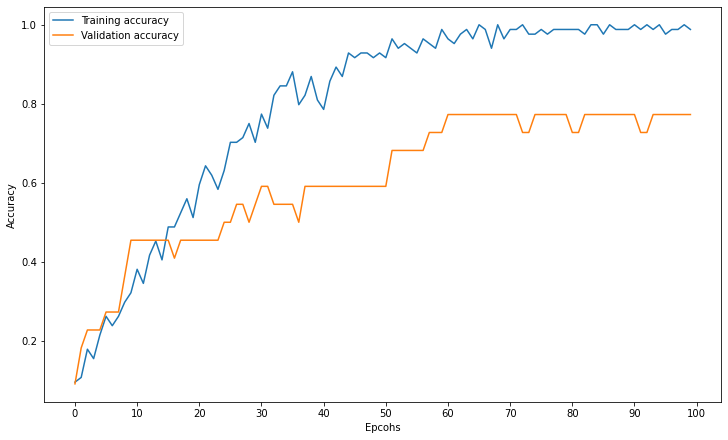

In [57]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["sparse_categorical_accuracy"], label="Training accuracy")
ax.plot(history.history["val_sparse_categorical_accuracy"], label="Validation accuracy")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(0, len(history.history["sparse_categorical_accuracy"]) + 1, 10))
ax.legend()
fig.savefig("accuracy.png")

In [58]:
metrics = model.evaluate(
    df_combined["text"].to_numpy(),
    df_combined["label_id"].to_numpy()
)

for metric_name, metric in zip(model.metrics_names, metrics):
    print(f"{metric_name:<8s}: {metric:.4f}")

4/4 [==============================] - 2s 380ms/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9528
loss    : 0.2462
sparse_categorical_accuracy: 0.9528


In [59]:
predictions_probabilities = model.predict(df_combined["text"])
predictions = np.argmax(predictions_probabilities, axis=1)

y_true = df_combined["label_id"].to_numpy()
accuracy = accuracy_score(y_true, predictions)
precision = precision_score(y_true, predictions, average="macro")
recall = precision_score(y_true, predictions, average="macro")
f1score = f1_score(y_true, predictions, average="macro")

print(f"accuracy : {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall   : {recall:.4f}")
print(f"F1       : {f1score:.4f}")

4/4 [==============================] - 2s 479ms/step
accuracy : 0.9528
precision: 0.9588
recall   : 0.9588
F1       : 0.9434


<AxesSubplot:>

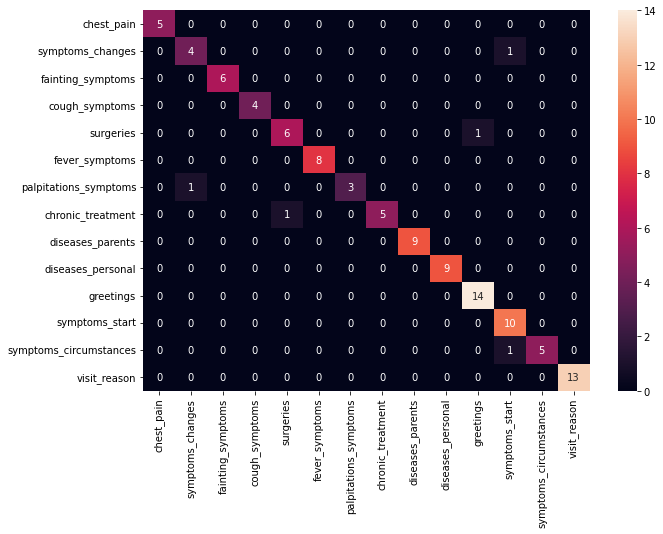

In [60]:
matrix = confusion_matrix(y_true, predictions)
index = label_to_idx.keys()
df = pd.DataFrame(matrix, index=index, columns=index)
plt.figure(figsize=(10, 7))
sns.heatmap(df, annot=True, fmt="d")
plt.savefig("confusion_matrix.png")